### SINDy-POD models for viscoelastic flows
Viscoelastic flows couple Navier-Stokes with a set of more complicated PDEs. Here we demonstrate that SINDy can generate high-dimensional, stable linear models for the evolution of the proper orthogonal modes obtained from fluid data.

In [1]:
# Import packages
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

In [2]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.load("data/fileWi3_5.npy")
t = A[:, 0]
A = A[:, 1:]

r = 40
threshold = 0.0
tfrac = 0.7  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]
x = A[:, :r]

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

# If you reduce nu, you will need more iterations 
# to make the A matrix negative definite
threshold = 0.0
sindy_opt = ps.StableLinearSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-12,  
    max_iter=10,
    tol=1e-10,
    verbose=True,
)

# Pure linear library
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)

model.fit(x_train, t=t_train)
Xi = model.coefficients()

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 2.8594e+01 ... 7.4526e+07 ... 0.0000e+00 ... 2.8594e+01
         1 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         2 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         3 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         4 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         5 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         6 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         7 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         8 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01
         9 ... 2.8594e+01 ... 1.3385e-04 ... 0.0000e+00 ... 2.8594e+01


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stable_linear_sr3.py:430: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10 iterations.
  ConvergenceWarning,


### Make sure that eigenvalues of the final model coefficients are all negative
This is the requirement for stability! Moreover, we want to check that the imaginary part of the eigenvalues is relatively unchanged, since this would mean we mangled the fitting!

In [3]:
print(np.sort(np.linalg.eigvals(sindy_opt.coef_history[0, :]))[-1])
print(np.sort(np.linalg.eigvals(Xi.T))[-1])
print(np.all(np.real(np.sort(np.linalg.eigvals(Xi.T))) < 0.0))

(0.00037944400483612417+0.2085630778132468j)
(-9.552625048619978e-09+0.031030282252936015j)
True


### Stability guarantee means we can simulate with new initial conditions
This is generally a substantial issue for nonlinear models.

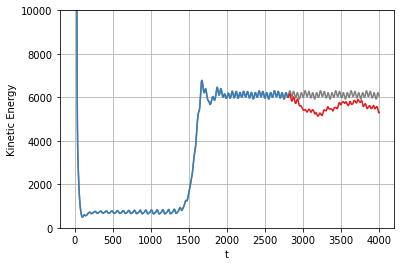

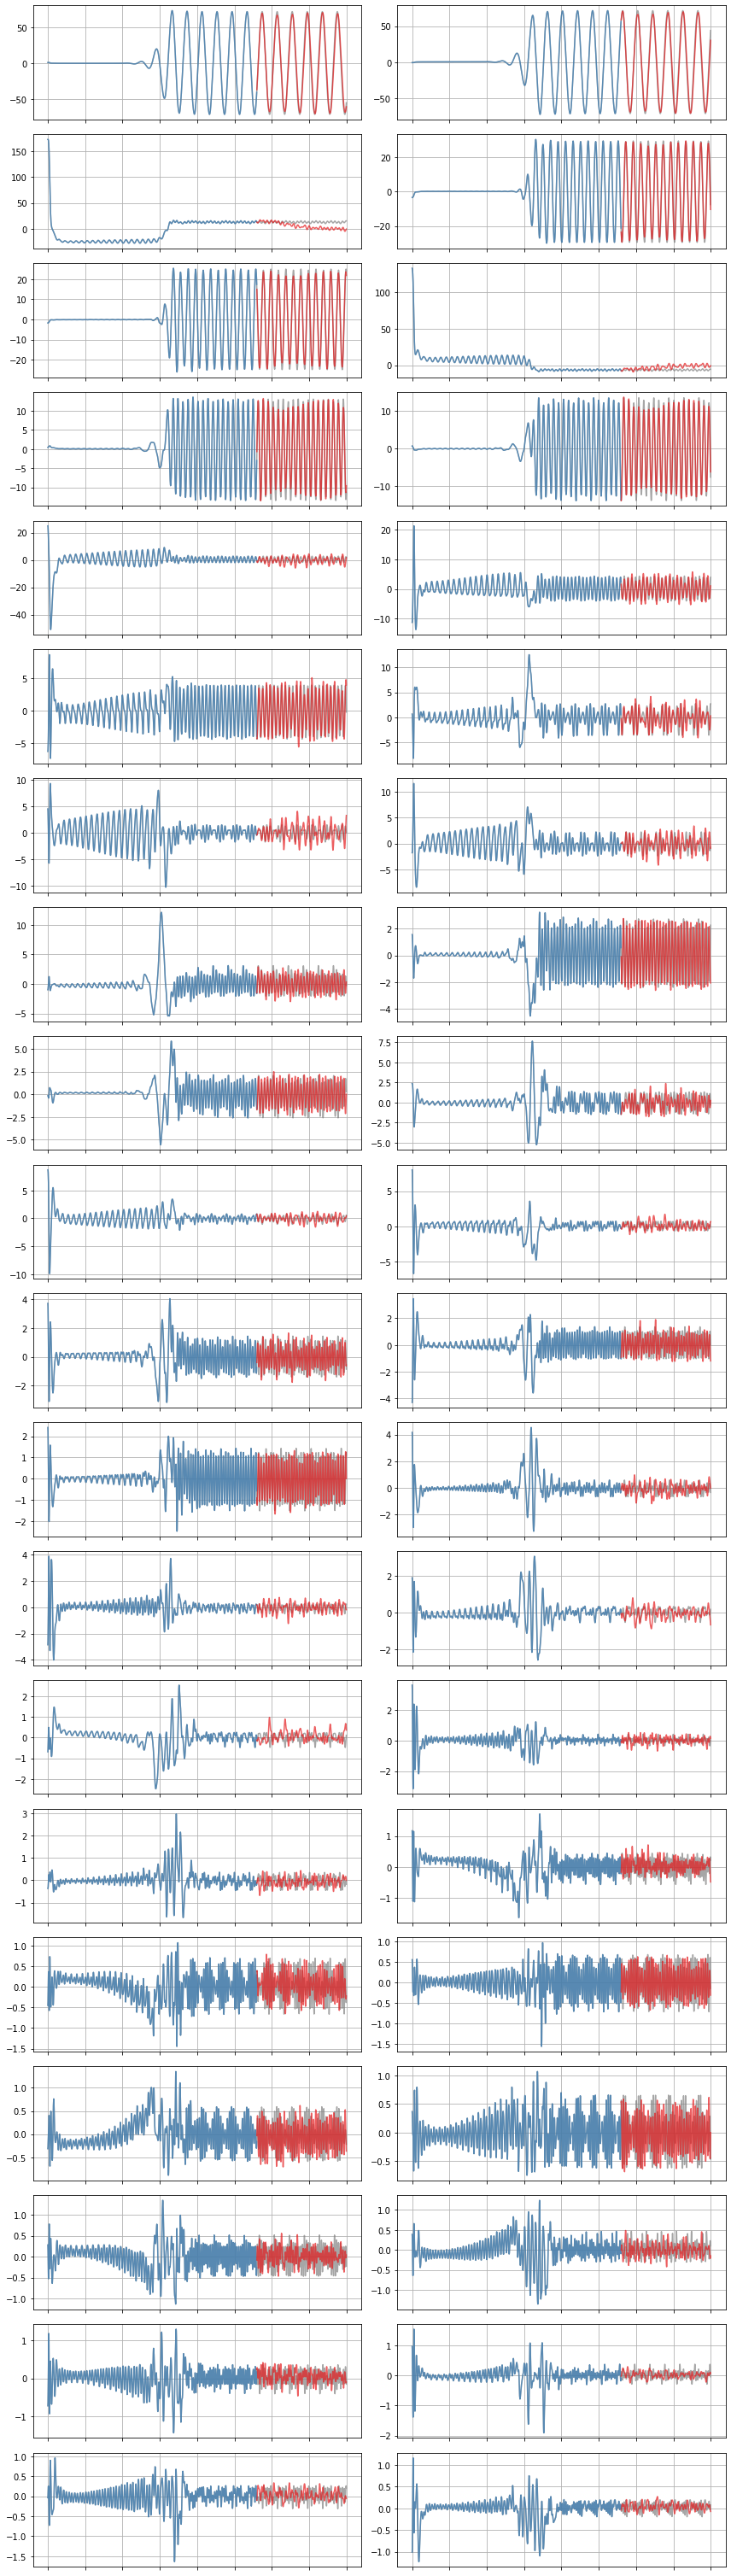

In [4]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, 
                            figsize=(12, 2 * (n_rows + 1)), 
                            sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), 
                label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), 
                label="Predicted (test)", **kws)

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[])

    fig.tight_layout()

# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# plot the total energy over the POD modes... 
plt.figure()
plt.plot(t, np.sum(x ** 2, axis=-1), color="Gray", label="True")
plt.plot(t_train, np.sum(x_train ** 2, axis=-1), color=cmap(1))
plt.plot(t_test, np.sum(x_sim ** 2, axis=-1), color=cmap(0))
plt.grid(True)
plt.ylim(0, 10000)
plt.xlabel('t')
plt.ylabel('Kinetic Energy')

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)
plt.show()